## Clean Data
- rename file: from 02020021rest 20150707 1720.mat -> 02020021.mat

In [ ]:
# import os
# import scipy.io as sio
# import numpy as np

# eegPath = "brain-mdd/dataset"
# newEEGPath = "brain-mdd/clean_dataset"

# for filename in os.listdir(eegPath):
#     if filename.endswith(".mat") or filename.endswith("..mat"):
#         data = sio.loadmat(eegPath + "/" + filename)
#         getKey = "a" + filename
#         getKey = getKey.replace(" ", "_")
#         getKey = getKey.replace("..", "")
#         getKey = getKey.replace(".", "")
#         if getKey in data:
#             temp = data[getKey]
#             newFilename = filename[:8]
#             np.save(newEEGPath + "/" + newFilename, temp)
#         else:
#             print(f"Key {getKey} not found in {filename}")
#     else:
#         print("Skipping " + filename)

## Inspect Data



In [12]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import enum
import mne

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

In [ ]:
# Get the path to the EEG data and report
eegPath = os.getenv("EEG_DIR_PATH")
reportPath = os.getenv("EEG_REPORT_PATH")

report = pd.read_excel(reportPath)
reportDf = pd.DataFrame(report)
reportDf

In [ ]:
filename = "02010004.npy"
data = np.load(eegPath + "/" + filename)

selectedChannelsEeg = []

for channel in ChannelMapping:
    print(channel)
    selectedChannelsEeg.append(data[channel.value])
    
# cast to 2 dimensional array
selectedChannelsEeg = np.array(selectedChannelsEeg)
selectedChannelsEeg = selectedChannelsEeg
selectedChannelsEeg.shape

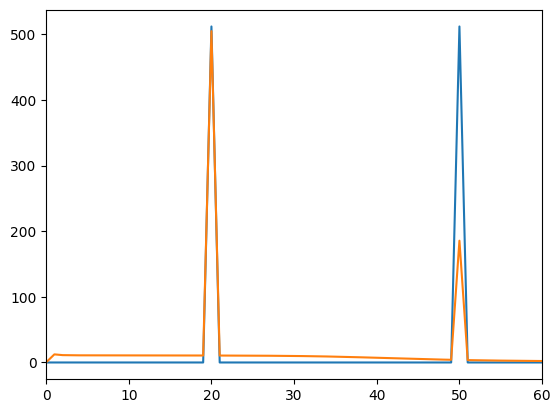

In [12]:
# generate sine wave of 20hz + 50hz
from scipy.signal import butter, lfilter

def fftProcess(inputBuffer):
    fftResults = []
    for channelData in inputBuffer:
        fftData = np.fft.fft(channelData)
        fftData = np.abs(fftData)
        fftData = fftData[0:int(len(channelData)/2)]
        fftResults.append(fftData)
    return fftResults

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

fs = 512*2
t = np.arange(0, 1024) / fs
signal = np.sin(2 * np.pi * 20 * t) + np.sin(2 * np.pi * 50 * t)
fftOri = np.fft.fft(signal)
fftOri = np.abs(fftOri)
fftOri = fftOri[0:int(len(fftOri)/2)]

filteredSignal = butter_bandpass_filter(signal, 0.5, 40, fs, order=4)
filteredFft = np.fft.fft(filteredSignal)
filteredFft = np.abs(filteredFft)
filteredFft = filteredFft[0:int(len(filteredFft)/2)]

# use my fft process


# plot compare between filtered and unfiltered signal
plt.plot(fftOri)
plt.plot(filteredFft)
plt.xlim(0, 60)
plt.show()

In [14]:
# Get the path to the EEG data and report
eegPath = os.getenv("EEG_DIR_PATH")
rawDataPath = os.getenv("EEG_DIR_PATH") + "/raw"
eeg16ChannelPath = os.getenv("EEG_DIR_PATH") + "/16channels"
filteredDataPath = os.getenv("EEG_DIR_PATH") + "/filtered"
reportPath = os.getenv("EEG_REPORT_PATH")

report = pd.read_excel(reportPath)
reportDf = pd.DataFrame(report)
# cast the subject id to string
reportDf["subject id"] = reportDf["subject id"].astype(str)
print(type(reportDf["subject id"][0]))

<class 'str'>


(129, 76039)
(16, 76039)
Creating RawArray with float64 data, n_channels=16, n_times=76039
    Range : 0 ... 76038 =      0.000 ...   304.152 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


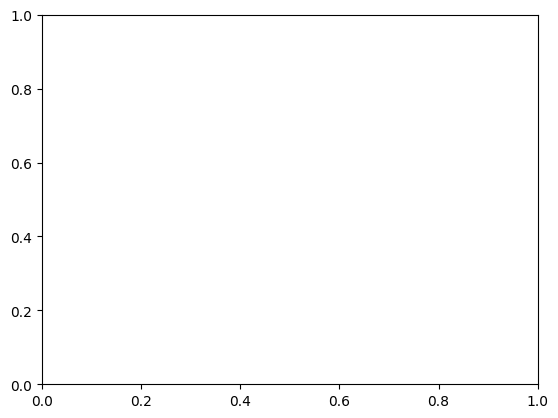

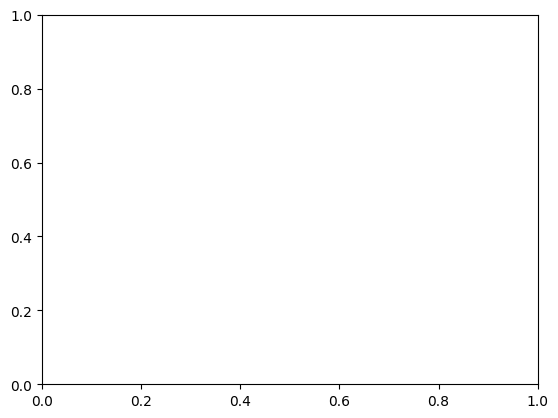

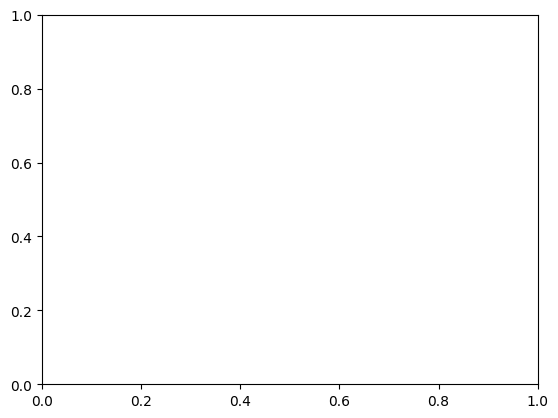

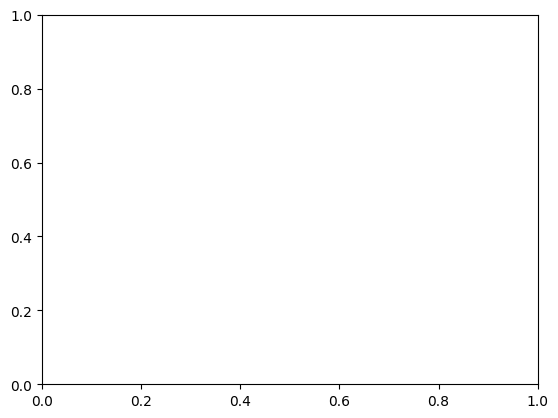

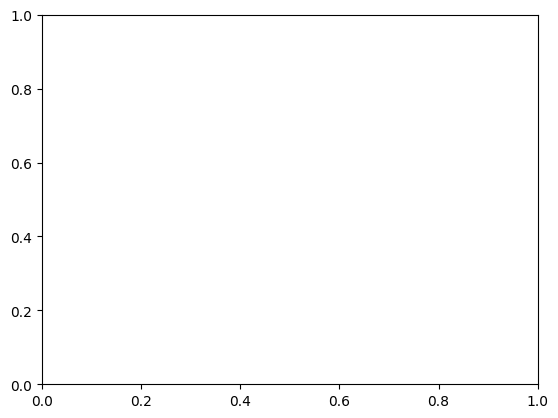

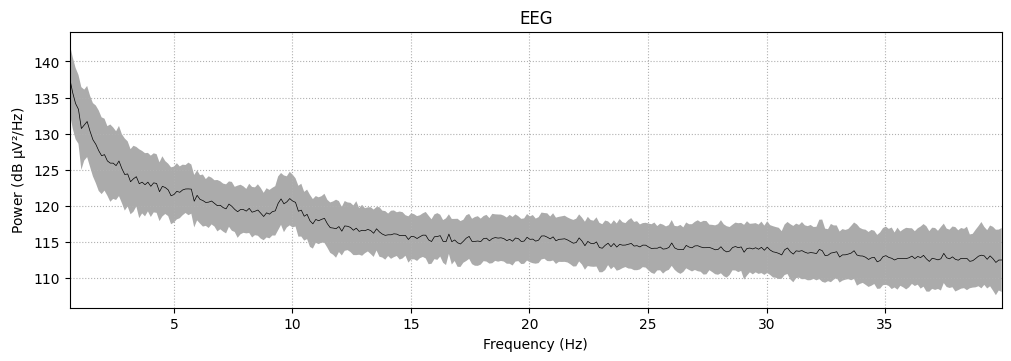

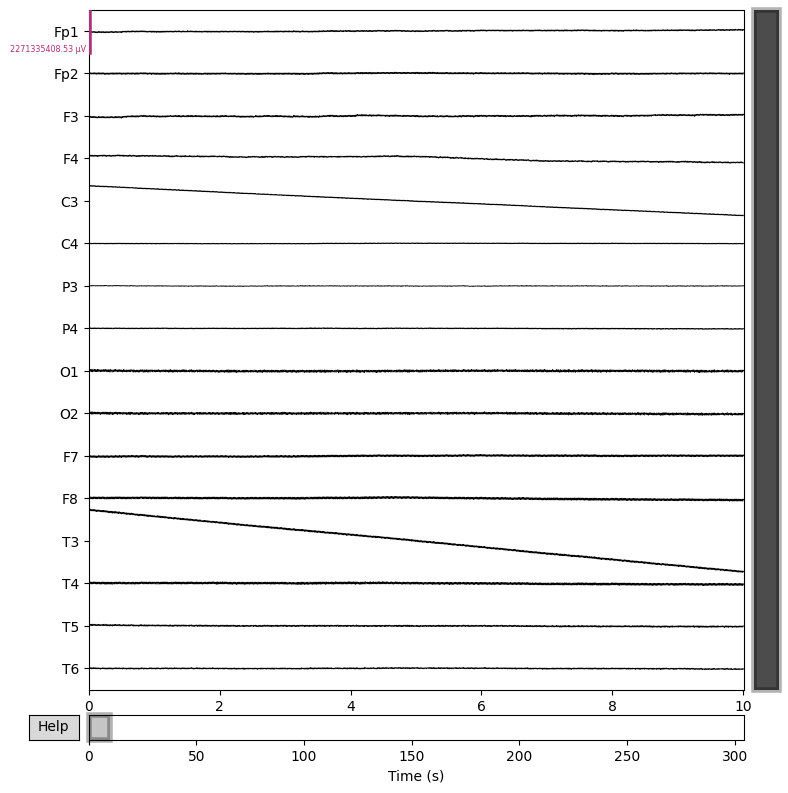

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (6.604 s)



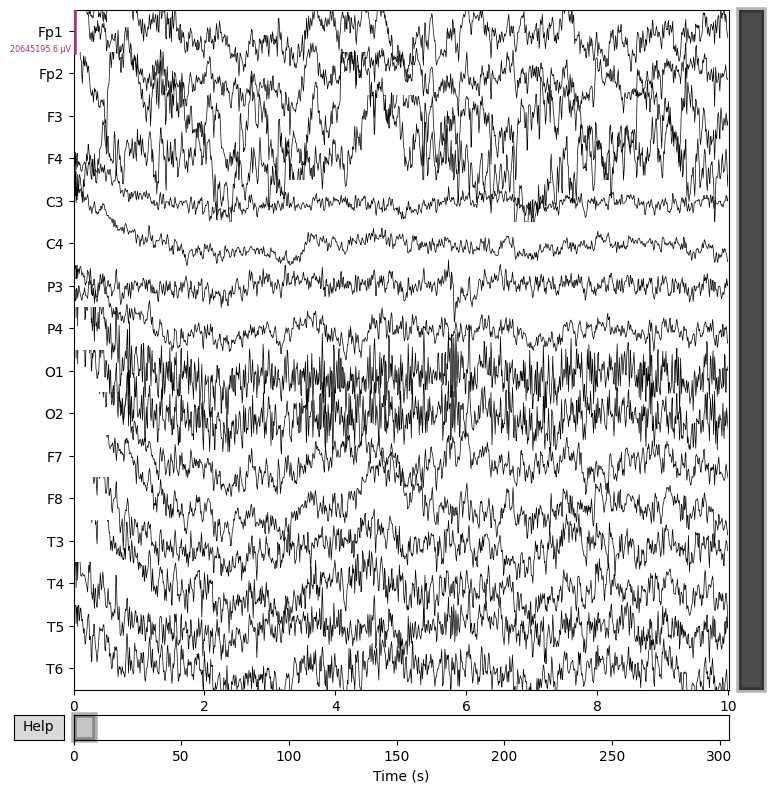

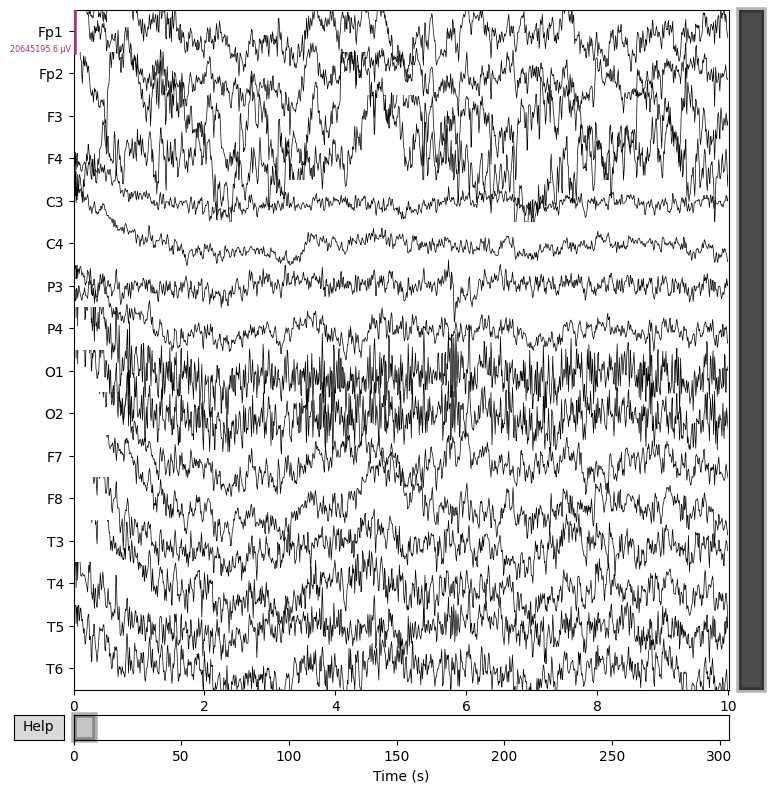

In [15]:
rawData = np.load(eegPath + "/raw/02020010.npy")
eegData = np.load(eegPath + "/16channels/02020010.npy")
print(rawData.shape)
print(eegData.shape)

channelNames = [channel.name for channel in ChannelMapping]
channelTypes = ['eeg'] * len(channelNames)

sfreq = 250
info = mne.create_info(channelNames, sfreq, channelTypes)
raw = mne.io.RawArray(eegData, info)

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

raw.plot_psd(fmin=0.5, fmax=40, average=True, spatial_colors=True) # plot power spectral density
raw.plot(n_channels=16, scalings='auto', title='Original')

# Bandpass filter 0.5-40 Hz
lowcut = 0.5
highcut = 40
raw.filter(lowcut, highcut, fir_design='firwin', skip_by_annotation='edge')

# plot topoplot
raw.plot(n_channels=16, scalings='auto', title='Original')



# # ICA
# ica = mne.preprocessing.ICA(n_components=16, random_state=42, max_iter='auto')
# ica.fit(raw)
# ica.plot_components()
# raw = ica.apply(raw)

# raw.plot_psd(fmin=0.5, fmax=40, average=True, spatial_colors=True)
# raw.plot(n_channels=16, scalings='auto', title='After ICA')

(16, 1)


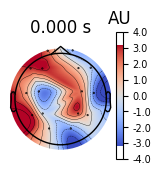

In [5]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Example t-test scores for 16 channels
t_test_scores = np.array([2.1, -1.5, 3.2, 0.5, -2.0, 1.8, -0.3, 2.5,
                          0.1, -1.8, 2.9, -0.9, 1.2, -2.3, 3.0, 0.6])

# Define channel names and standard 10-20 positions
channel_names = [
    'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4',
    'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6'
]
montage = mne.channels.make_standard_montage('standard_1020')

# Create an info structure
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage)

# Create a data array with shape (n_channels, n_times)
# Since we only have t-test scores, we'll use a single time point
data = t_test_scores[:, np.newaxis]
print(data.shape)

# Create an Evoked object (required for topomap plotting)
evoked = mne.EvokedArray(data, info)

# Plot topomap
evoked.plot_topomap(times=0, scalings=dict(eeg=1), time_unit='s', cmap='coolwarm')

plt.show()


In [9]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Example data: t-test scores for each channel (replace with your actual data)
t_test_scores = np.array([0.5, 1.2, -0.8, 0.6, 1.0, -1.5, 0.7, -0.3,
                          1.1, -0.9, 0.8, 1.3, -1.0, -0.7, 0.9, -0.4])

# Use MNE's standard montage to get channel positions (standard_1020 system)
montage = mne.channels.make_standard_montage('standard_1020')
pos = montage.get_positions()['ch_pos']

# Extract x, y positions and corresponding t-test values for the plot
x_pos = np.array([pos[channel][0] for channel in pos])
y_pos = np.array([pos[channel][1] for channel in pos])

# Create a custom plot using matplotlib
fig, ax = plt.subplots()

# Create a scatter plot for the topomap
sc = ax.scatter(x_pos, y_pos, c=t_test_scores, s=200, cmap='coolwarm', edgecolors='k')

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('--- Feature Difference')

# Set title
ax.set_title('Topo T-Test Difference')

# Adjust the axis and labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')

# Optionally, add EEG channel labels (if desired)
for i, channel in enumerate(pos):
    ax.text(x_pos[i] + 0.02, y_pos[i] + 0.02, channel, fontsize=8)

plt.show()


ValueError: 'c' argument has 16 elements, which is inconsistent with 'x' and 'y' with size 94.

In [3]:
import numpy as np
from scipy.stats import ttest_ind

# Example data
num_epoch, num_channel = 1000, 16
control = np.random.rand(num_epoch, num_channel)  # Replace with real data
test = np.random.rand(num_epoch, num_channel)     # Replace with real data

# Initialize an array to store t-test scores
t_test_scores = np.zeros(num_channel)

# Perform t-tests for each channel
for channel_idx in range(num_channel):
    # Extract data for the current channel
    control_data = control[:, channel_idx]
    test_data = test[:, channel_idx]

    # Perform t-test
    t_stat, _ = ttest_ind(control_data, test_data, equal_var=False)  # Welch's t-test
    t_test_scores[channel_idx] = t_stat

# t_test_scores now contains the t-test scores for all 16 channels
print("T-test scores for each channel:")
print(t_test_scores)


T-test scores for each channel:
[-0.08231825  1.34234692 -0.27411633 -0.37471818 -0.1214735  -0.91460503
 -0.45199208  0.3806226   1.08717366  0.56411666  0.33563023  1.62779416
 -2.59348344 -0.77729792  2.06931329  0.66490505]


In [4]:
import numpy as np
from scipy.stats import ttest_ind

# Example data
num_epoch, num_feature, num_channel = 1000, 5, 16
control = np.random.rand(num_epoch, num_feature, num_channel)  # Replace with real data
test = np.random.rand(num_epoch, num_feature, num_channel)     # Replace with real data

# Select one feature (e.g., first feature)
feature_idx = 0  # Index of the feature you want to focus on

# Initialize an array to store t-test scores for all channels
t_test_scores = np.zeros(num_channel)

# Perform t-tests for the selected feature across all channels
for channel_idx in range(num_channel):
    # Extract data for the current channel and the selected feature
    control_data = control[:, feature_idx, channel_idx]
    test_data = test[:, feature_idx, channel_idx]

    # Perform t-test
    t_stat, _ = ttest_ind(control_data, test_data, equal_var=False)  # Welch's t-test
    t_test_scores[channel_idx] = t_stat

# t_test_scores now contains the t-test scores for the selected feature across all channels
print("T-test scores for the selected feature across all channels:")
print(t_test_scores)


T-test scores for the selected feature across all channels:
[ 0.10844822  0.19343391 -0.29283291 -0.91159905  0.16974097  0.47135568
 -1.20113088  0.43309187 -0.42174187  0.21629239 -0.44962741  1.14830633
 -0.75360927 -0.0209005   0.75272691  0.14467784]
